In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
import cv2
import imghdr
import os
data_dir = 'trash/validate' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

KeyboardInterrupt: 

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "trash/train",
    image_size = (img_height, img_width),
    seed = 123,
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "trash/validate",
    image_size = (img_height, img_width),
    seed = 123,
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "trash/test",
    image_size = (img_height, img_width),
    seed = 123,
    batch_size = batch_size
)

Found 7524 files belonging to 4 classes.
Found 1531 files belonging to 4 classes.
Found 2562 files belonging to 4 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['biological', 'glass', 'paper', 'plastic']


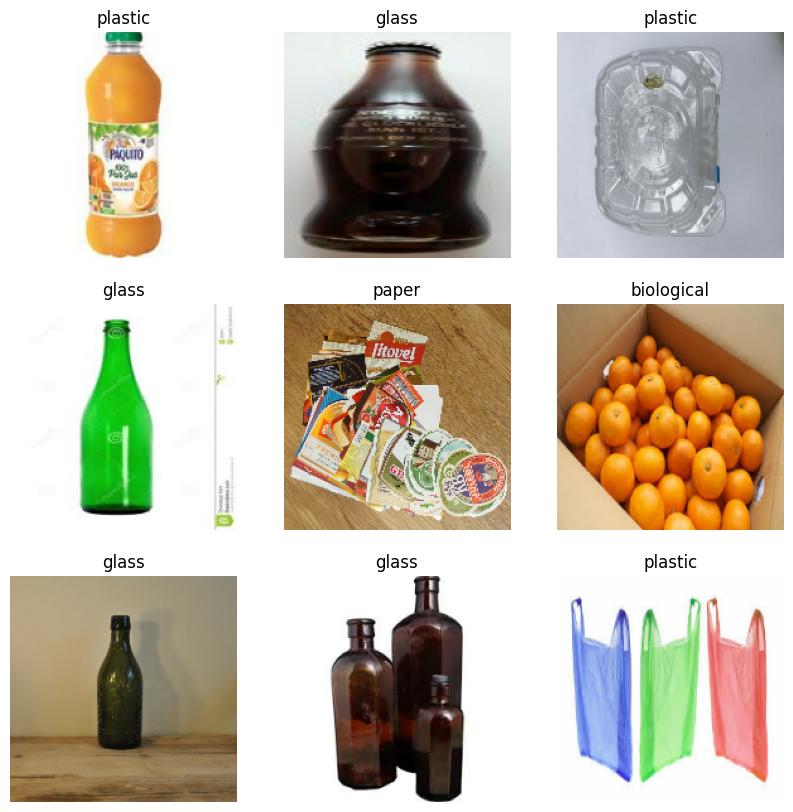

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
236/236 [==============================] - 101s 426ms/step - loss: 0.9672 - accuracy: 0.5795 - val_loss: 0.8036 - val_accuracy: 0.6656
Epoch 2/10
236/236 [==============================] - 118s 499ms/step - loss: 0.6830 - accuracy: 0.7228 - val_loss: 0.6583 - val_accuracy: 0.7466
Epoch 3/10
236/236 [==============================] - 103s 433ms/step - loss: 0.5218 - accuracy: 0.7920 - val_loss: 0.5555 - val_accuracy: 0.7884
Epoch 4/10
236/236 [==============================] - 98s 415ms/step - loss: 0.3826 - accuracy: 0.8542 - val_loss: 0.6888 - val_accuracy: 0.7688
Epoch 5/10
236/236 [==============================] - 97s 413ms/step - loss: 0.2760 - accuracy: 0.8970 - val_loss: 0.5302 - val_accuracy: 0.8295
Epoch 6/10
236/236 [==============================] - 97s 410ms/step - loss: 0.1951 - accuracy: 0.9269 - val_loss: 0.6208 - val_accuracy: 0.8184
Epoch 7/10
236/236 [==============================] - 96s 408ms/step - loss: 0.1234 - accuracy: 0.9545 - val_loss: 0.6179 - val

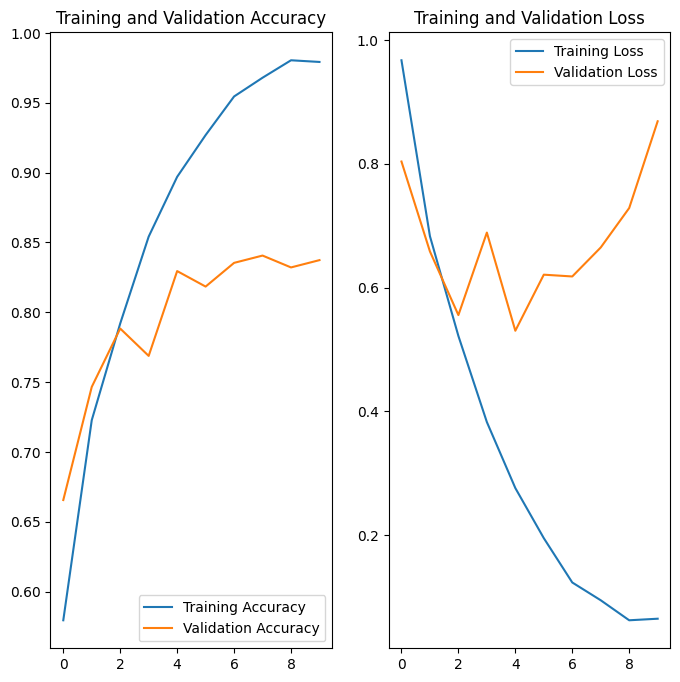

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

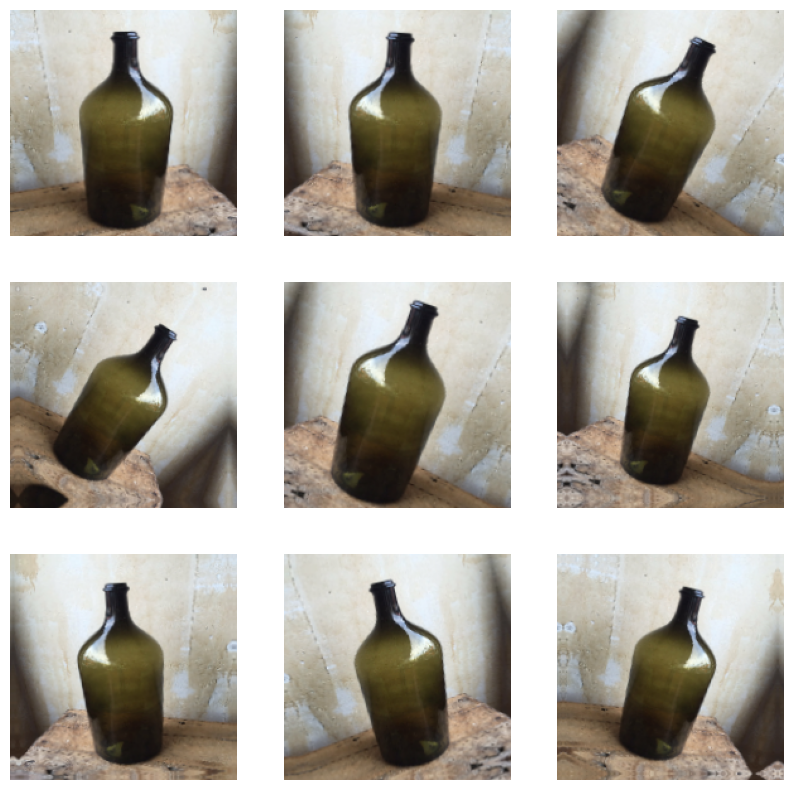

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
236/236 [==============================] - 109s 459ms/step - loss: 1.0434 - accuracy: 0.5354 - val_loss: 0.8396 - val_accuracy: 0.6251
Epoch 2/15
236/236 [==============================] - 109s 463ms/step - loss: 0.8393 - accuracy: 0.6411 - val_loss: 0.7897 - val_accuracy: 0.6558
Epoch 3/15
236/236 [==============================] - 117s 496ms/step - loss: 0.7672 - accuracy: 0.6809 - val_loss: 0.7359 - val_accuracy: 0.7035
Epoch 4/15
236/236 [==============================] - 120s 508ms/step - loss: 0.7099 - accuracy: 0.7027 - val_loss: 0.7405 - val_accuracy: 0.6871
Epoch 5/15
236/236 [==============================] - 115s 489ms/step - loss: 0.6702 - accuracy: 0.7240 - val_loss: 0.7335 - val_accuracy: 0.7211
Epoch 6/15
236/236 [==============================] - 109s 461ms/step - loss: 0.6064 - accuracy: 0.7582 - val_loss: 0.7130 - val_accuracy: 0.7302
Epoch 7/15
236/236 [==============================] - 109s 460ms/step - loss: 0.5666 - accuracy: 0.7727 - val_loss: 0.6493 -

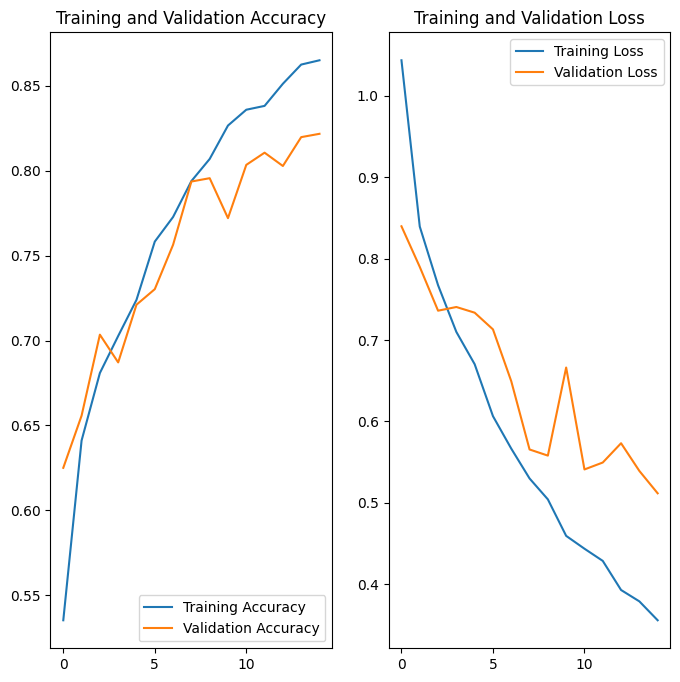

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
model.evaluate(test_ds)

81/81 [==============================] - 9s 110ms/step - loss: 0.6138 - accuracy: 0.8009


[0.6138237714767456, 0.800936758518219]

In [25]:
model.save("m_with_data_augmentation.h5")

In [34]:
sunflower_path = "trash/test/biological/biological476.jpg"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 22ms/step
This image most likely belongs to biological with a 90.06 percent confidence.
